<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    Mini-Challenge 2:<br>Paper-Studium und Umsetzung
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Gabriel Torres Gamez im HS 2023.
</p>

## Ziel
Für diese Mini Challenge bearbeite ich das Paper [Vinyals, O., Toshev, A., Bengio, S., & Erhan, D. (2014, November 17). Show and Tell: A Neural Image Caption Generator. arXiv.Org.](https://doi.org/10.48550/arXiv.1411.4555). In diesem Paper wird ein Modell vorgestellt, das Bilder in natürliche Sprache beschreibt (Image Captioning). Es kombiniert Convolutional Neural Networks (CNN) und Long Short-Term Memory Networks (LSTM), wobei der Output des CNN mit den tokenisierten Bildbeschreibungen (Captions) konkatiniert und dann in das LSTM-Netzwerk eingespeist wird. Das Modell wird auf dem Datensatz [Hodosh, M., Young, P., & Hockenmaier, J. (2013, August 30). Flickr8k Dataset.
](http://hockenmaier.cs.illinois.edu/8k-pictures.html) trainiert.

## Setup
Hier werden alle benötigten Bibliotheken importiert und Einstellungen vorgenommen.

In [1]:
# Standard Libraries
import os
import sys
import logging
import warnings

from collections import defaultdict

# 3rd Party Libraries
import matplotlib as mpl
import nltk
import numpy as np
import pandas as pd
import pytorch_lightning as li
import torch
import torchmetrics
import torchvision
import wandb


from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize as nltk_word_tokenize
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics.text.bleu import BLEUScore
from torchvision import transforms

# Print information about the environment
print("Packages: ")
print(f" | Python Version: {sys.version}")
print(f" | Matplotlib Version: {mpl.__version__}")
print(f" | NLTK Version: {nltk.__version__}")
print(f" | Numpy Version: {np.__version__}")
print(f" | Pandas Version: {pd.__version__}")
print(f" | PyTorch Lightning Version: {li.__version__}")
print(f" | PyTorch Version: {torch.__version__}")
print(f" | Torchmetrics Version: {torchmetrics.__version__}")
print(f" | Torchvision Version: {torchvision.__version__}")
print(f" | Wandb Version: {wandb.__version__}")
print()

print("Backends: ")
print(f" | CUDA: {torch.cuda.is_available()}")
print(f"   | CUDA Built: {torch.backends.cuda.is_built()}")
print(f" | MPS: {torch.backends.mps.is_available()}")
print(f"   | MPS Built: {torch.backends.mps.is_built()}")
print()

print("Ressources: ")
print(f" | CPU Threads: {torch.get_num_threads()}")
for i in range(torch.cuda.device_count()):
    print(f" | GPU {i+1}: {torch.cuda.get_device_name(i)}\n")

# Settings
torch.set_float32_matmul_precision("high")
nltk.download('punkt')
torch.manual_seed(0)

# Silence warnings
%env WANDB_SILENT=True
warnings.filterwarnings("ignore")
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

# Final message
print("Setup complete!\n")

Packages: 
 | Python Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
 | Matplotlib Version: 3.8.2
 | NLTK Version: 3.8.1
 | Numpy Version: 1.26.2
 | Pandas Version: 2.1.3
 | PyTorch Lightning Version: 2.1.0
 | PyTorch Version: 2.1.1+cu121
 | Torchmetrics Version: 1.2.0
 | Torchvision Version: 0.16.1+cu121
 | Wandb Version: 0.16.0

Backends: 


 | CUDA: True
   | CUDA Built: True
 | MPS: False
   | MPS Built: False

Ressources: 
 | CPU Threads: 16
 | GPU 1: NVIDIA GeForce RTX 3080



[nltk_data] Downloading package punkt to
[nltk_data]     /home2/g.torresgamez/nltk_data...


env: WANDB_SILENT=True
Setup complete!



[nltk_data]   Package punkt is already up-to-date!


Hier werden alle benötigten Konstanten definiert.

In [2]:
# Files
IMG_PATH = "data/images"
ANN_FILE = "data/captions.txt"

# Data Module
BATCH_SIZE = 64
NUM_WORKERS = 7 # number of CPU cores - 1 | 0 on Apple Silicon
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Special Tokens
START_TOKEN = "<start>"
END_TOKEN = "<end>"
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"
SPECIAL_TOKENS = [START_TOKEN, END_TOKEN, PAD_TOKEN, UNK_TOKEN]

Hier wird der Tokenizer definiert. Wir nehmen für diese Mini Challenge den Word Tokenizer `(nltk_word_tokenize)` von NLTK.

In [3]:
tokenizer = nltk_word_tokenize

## Arbeitsschritte

### Schritt 1: Daten 
In diesem Schritt lesen wir die Daten ein und bereiten sie für das Training vor.

Hier finden wir alle verschiedenen Captions für jedes Bild.

In [4]:
# read annotations as df
ann = pd.read_csv(ANN_FILE, sep=",")
ann

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


Hier definieren wir anhand der Daten und des Tokenizers die Vokabulargrösse und die maximale Länge der Captions (mit Start- und Endtoken).

In [5]:
all_tokens_set = set(ann["caption"].apply(tokenizer).explode().tolist())

VOCAB_SIZE = len(all_tokens_set) + len(SPECIAL_TOKENS) 
MAX_CAPTION_LENGTH = ann["caption"].apply(tokenizer).apply(len).max() + 2  # + start & end token

print(f"Vocabulary Size:\t\t\t{VOCAB_SIZE}")
print(f"Max. Number of Tokens in a caption:\t{MAX_CAPTION_LENGTH}")

Vocabulary Size:			9634
Max. Number of Tokens in a caption:	40


Hier erstellen wir ein Vokabular, welches die Tokens in Zahlen umwandelt (und umgekehrt).
Zusätzlich erstellen wir eine Funktion, welches jede Caption mit Start- und Endtoken versieht und diese auf die maximale Länge paddet.

In [6]:
# vocabulary which maps tokens to indices
vocab = {token: idx for idx, token in enumerate(sorted(all_tokens_set))}
for token in SPECIAL_TOKENS:
    vocab[token] = len(vocab)
    
# inverse vocabulary which maps indices to tokens
inv_vocab = {idx: token for token, idx in vocab.items()} # für rücktransformation

# convert tokens str to int, if token not in vocab, use unk_token
def tokens_str_to_int(tokens):
    return [vocab.get(token, vocab[UNK_TOKEN]) for token in tokens] 

# converts tokens int to str, if token not in vocab, use unk_token
def tokens_int_to_str(tokens_idx):
    return [inv_vocab.get(idx, UNK_TOKEN) for idx in tokens_idx]

# converts a string to a list of tokens with the length max_num_tokens
def text_process(text):
    tokenized_text = [START_TOKEN] + tokenizer(text) + [END_TOKEN]
    n_pad = MAX_CAPTION_LENGTH - len(tokenized_text)
    return tokenized_text + n_pad * [PAD_TOKEN]

example_caption = ann["caption"][0]
print(f"Example caption:\n{example_caption}\n")
print(f"Tokenized caption:\n{text_process(example_caption)}\n")
print(f"Tokenized caption (int):\n{tokens_str_to_int(text_process(example_caption))}\n")

Example caption:
A child in a pink dress is climbing up a set of stairs in an entry way .

Tokenized caption:
['<start>', 'A', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

Tokenized caption (int):
[9630, 68, 2580, 4910, 1240, 6514, 3457, 4995, 2675, 9105, 1240, 7526, 6030, 8185, 4910, 1411, 3665, 9334, 13, 9631, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632]



Hier definieren wir das Preprocessing der Bilder. Wir skalieren jedes Bild auf 3x224x224.

In [7]:
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

Hier erstellen wir das DataSet, welches uns die Bilder, die Captions und die umgewandelten Captions (int) zurückgibt.

In [8]:
# define dataset
class Flickr8kDataSet(Dataset):
    def __init__(self, ann):
        self.ann = ann.reset_index(drop=True)

    def __len__(self):
        return len(self.ann)

    def __getitem__(self, idx):
        # Tokenized Caption as str
        target = self.ann.iloc[idx].caption
        target = text_process(target)
        
        # Tokenized Caption as int
        target_idx = tokens_str_to_int(target)
        target_idx = torch.tensor(target_idx)

        # Image 
        image_path = os.path.join(IMG_PATH, self.ann.iloc[idx].image)
        image = torchvision.io.read_image(image_path)
        image = transform(image)

        return image, target, target_idx

Hier schauen wir uns ein Beispiel an.

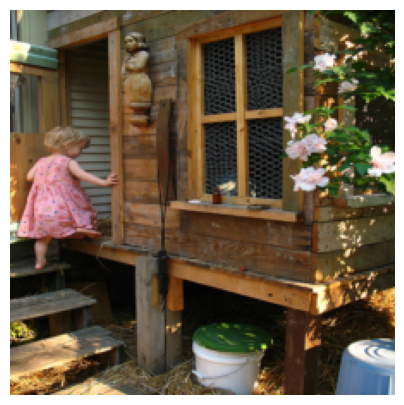

Caption: A child in a pink dress is climbing up a set of stairs in an entry way .


In [9]:
def plot_img(image, caption):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")
    plt.show()
    print(f"Caption: {' '.join([token for token in caption if token not in [START_TOKEN, END_TOKEN, PAD_TOKEN]])}")

# get a picture and caption
full_dataset_iter = iter(Flickr8kDataSet(ann))
images, caption, _ = next(full_dataset_iter)
plot_img(images, caption)

Jetzt erstellen wir das DataModule. In diesem werden die Daten geladen, in Train-, Val- und Testset aufgeteilt und die DataLoader erstellt.

In [10]:
class Flickr8kDataModule(li.LightningDataModule):
    def __init__(self):
        super().__init__()
        
    def setup(self, stage=None):
        # split by image
        images = ann.image.unique()
        
        # calculate splitsizes
        n_images = len(images)
        n_val_samples = int(n_images * VAL_RATIO)
        n_test_samples = int(n_images * TEST_RATIO)

        # split
        torch.manual_seed(27112000)
        image_split = random_split(
            images,
            [
                n_images - n_val_samples - n_test_samples,
                n_val_samples,
                n_test_samples,
            ]
        )

        # retrieve image from split
        train_images = images[image_split[0].indices]
        val_images = images[image_split[1].indices]
        test_images = images[image_split[2].indices]
        
        # convert to df for dataset
        train_ann = ann[ann["image"].isin(train_images)]
        val_ann = ann[ann["image"].isin(val_images)]
        test_ann = ann[ann["image"].isin(test_images)]

        # get datasets
        self.train_dataset = Flickr8kDataSet(train_ann)
        self.val_dataset = Flickr8kDataSet(val_ann)
        self.test_dataset = Flickr8kDataSet(test_ann)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

Wir erstellen dieses DataModule und schauen uns ein Beispiel an.

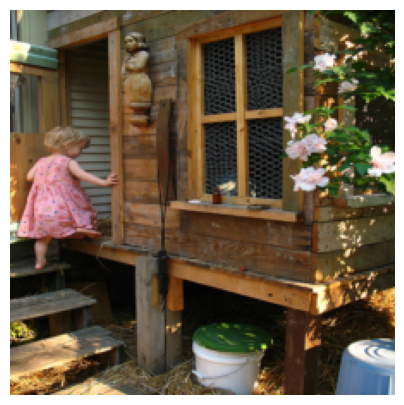

Caption: A child in a pink dress is climbing up a set of stairs in an entry way .


In [11]:
flickr8k = Flickr8kDataModule()
flickr8k.setup()

images, caption, caption_tensor = flickr8k.train_dataset[0]
plot_img(images, caption)

Seems to be working :)

### Schritt 2: Aufbau Modellierung 
Hier erstellen wir das Modell. Als Vorbereitung erstellen wir dafür einen `ImageEncoder`, welches die Bilder in numerische Features umwandelt, einen `CaptionEncoder`, welches die Tokens mit den gleichen Dimensionen Embedded und einen `CaptioningDecoder`, welcher das LSTM trainiert und neue Tokens vorhersagt.

Der `ImageEncoder` ist so aufgebaut, dass verschiedene EfficinetNets, ResNets, VGGs und ViTs verwendet werden können. Anstatt den letzten Layer zu trainieren, wird der letzte Layer ersetzt und ein Dropout Layer mit nachfolgendem Linear Layer hinzugefügt. Somit kann Overfitting verhindert werden. Im Paper wird angegeben, dass Dropout das Modell noch besser gemacht hat.

In [12]:
class ImageEncoder(torch.nn.Module):
    def __init__(self, cnn_model, embed_size, p_dropout):
        super().__init__()

        try:
            # load the model
            self.model = torchvision.models.get_model(cnn_model, weights="DEFAULT")

            # freeze all the layers
            for param in self.model.parameters():
                param.requires_grad = False

            # replace the classifier layer on efficientnet
            if cnn_model.startswith("efficientnet"):
                self.model.classifier = nn.Sequential(
                    nn.Dropout(p=p_dropout),
                    nn.Linear(self.model.classifier[-1].in_features, embed_size),
                )

            # replace the fc layer on resnet
            elif cnn_model.startswith("resnet"):
                self.model.fc = nn.Sequential(
                    nn.Dropout(p=p_dropout),
                    nn.Linear(self.model.fc.in_features, embed_size),
                )

            # replace the last classifier layer on vgg
            elif cnn_model.startswith("vgg"):
                self.model.classifier[-1] = nn.Sequential(
                    nn.Dropout(p=p_dropout),
                    nn.Linear(self.model.classifier[-1].in_features, embed_size),
                )

            # replace the head layer on vit
            elif cnn_model.startswith("vit"):
                self.model.heads.head = nn.Sequential(
                    nn.Dropout(p=p_dropout),
                    nn.Linear(self.model.heads.head.in_features, embed_size),
                )

            else:
                raise ValueError(f"Transfer Learning on Model {cnn_model} not implemented!")
            
        except Exception as e:
            raise ValueError(f"Cannot load model {cnn_model}!") from e

    def forward(self, x):
        return self.model(x)
    
class CaptionEncoder(torch.nn.Embedding):
    def __init__(self, vocab_size, embed_size):
        # initialize the nn.Embedding base class
        super().__init__(vocab_size, embed_size)

class CaptioningDecoder(torch.nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super().__init__()
        
        # define the LSTM layer
        self.lstm = torch.nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        
        # define the output layer
        self.linear = torch.nn.Linear(hidden_size, vocab_size)
        
    def forward(self, input):
        # forward pass
        output, _ = self.lstm(input)
        output = self.linear(output)

        # softmaxing
        return torch.nn.functional.log_softmax(output, dim=-1)

Hier testen wir, ob unsere Encoder und Decoder funktionieren.

In [13]:
# Parameters for testing
cnn_model = "efficientnet_b0" # list of models: torchvision.models.list_models()
embed_size = 400
p_dropout_cnn = 0.2
hidden_size_lstm = 1000
num_layers_lstm = 1

# Test Image Encoder dimensions
img_encoder = ImageEncoder(cnn_model, embed_size, p_dropout_cnn)
img_encoder_out = img_encoder(images.unsqueeze(0))
assert img_encoder(images.unsqueeze(0)).shape[1] == embed_size
print("Image Encoder: OK")
print(f"Image Encoder Output Shape: {img_encoder_out.shape}\n")

# Test Caption Encoder dimensions
cap_encoder = CaptionEncoder(VOCAB_SIZE, embed_size)
cap_encoder_out = cap_encoder(caption_tensor.unsqueeze(0))
assert cap_encoder_out.shape[2] == embed_size
print("Caption Encoder: OK")
print(f"Caption Encoder Output Shape: {cap_encoder_out.shape}\n")

# Print concatenation dimensions
encoded_input = torch.cat((img_encoder_out.unsqueeze(1), cap_encoder_out), 1)
print(f"Encoded Input Shape: {encoded_input.shape}\n")

# Test Caption Decoder dimensions
cap_decoder = CaptioningDecoder(embed_size, hidden_size_lstm, VOCAB_SIZE, num_layers_lstm)
cap_decoder_out = cap_decoder(encoded_input)
assert cap_decoder_out.shape[2] == VOCAB_SIZE
print("Caption Decoder: OK")
print(f"Caption Decoder Output Shape: {cap_decoder_out.shape}")

Image Encoder: OK
Image Encoder Output Shape: torch.Size([1, 400])

Caption Encoder: OK
Caption Encoder Output Shape: torch.Size([1, 40, 400])

Encoded Input Shape: torch.Size([1, 41, 400])



Caption Decoder: OK
Caption Decoder Output Shape: torch.Size([1, 41, 9634])


Seems to be working :)

Die Encoder und Decoder werden im `ShowAndTell` Modell zusammengeführt. <br>
Hier ist es wichtig anzumerken, dass die `forward` Methode des Modells nur im während dem Training verwendet wird, da beim Vorhersagen die Caption nicht bekannt ist und somit nicht mitgegeben werden kann. Um eine Caption aus nur einem Bild zu generieren, wird die `predict` Methode verwendet.<br>
Auch noch Wissenswert: Bei der `forward` Methode wird automatisch Teacher Forcing verwendet. [Melchior, M. (2023, November 20). Teacher Forcing in PyTorch. Spaces.](https://spaces.technik.fhnw.ch/spaces/deep-learning/beitraege/teacher-forcing-in-pytorch#teacher-forcing-in-pytorch)

In [14]:
class ShowAndTell(li.LightningModule):
    def __init__(self, optimizer, lr, weight_decay, cnn_model, embed_size, p_dropout_cnn, vocab_size, hidden_size_lstm, num_layers_lstm, max_caption_length):
        super().__init__()
        self.optimizer = optimizer
        self.lr = lr
        self.weight_decay = weight_decay
        self.cnn_model = cnn_model
        self.embed_size = embed_size
        self.p_dropout_cnn = p_dropout_cnn
        self.vocab_size = vocab_size
        self.hidden_size_lstm = hidden_size_lstm
        self.num_layers_lstm = num_layers_lstm
        self.max_caption_length = max_caption_length
        
        # initializing the submodules
        self.img_encoder = ImageEncoder(self.cnn_model, self.embed_size, self.p_dropout_cnn)
        self.caption_encoder = CaptionEncoder(self.vocab_size, self.embed_size)
        self.captioning_decoder = CaptioningDecoder(self.embed_size, self.hidden_size_lstm, self.vocab_size, self.num_layers_lstm)
        
        # loss function 
        self.loss_function = nn.CrossEntropyLoss()

        # metrics
        self.bleu1_metric = BLEUScore(n_gram=1)

        # metric dicts
        self.val_scores = defaultdict(list)
        self.test_scores = defaultdict(list)
    
    def forward(self, images, captions):
        # encode the images and captions
        embedded_images = self.img_encoder(images).unsqueeze(1)
        embedded_captions = self.caption_encoder(captions)
        
        # concatenate the features and captions
        embedded_captions = torch.cat((embedded_images, embedded_captions), 1)

        # decode the captions
        return self.captioning_decoder(embedded_captions)
    
    def predict(self, images, max_caption_length=None):
        with torch.no_grad():

            # set the maximum caption length if not specified
            if max_caption_length is None:
                max_caption_length = self.max_caption_length

            # encode the images
            embedded_images = self.img_encoder(images).unsqueeze(1)

            # initialize the caption with the start token
            current_tokens = torch.tensor(tokens_str_to_int([START_TOKEN]), device=images.device)
            current_tokens = current_tokens.repeat(len(images), 1)

            for _ in range(max_caption_length-1):
                # encode the current tokens
                embedded_captions = self.caption_encoder(current_tokens)
                embedded_captions = torch.cat((embedded_images, embedded_captions), 1)
                
                # decode the captions
                output = self.captioning_decoder(embedded_captions).argmax(dim=-1)

                # append the predicted token to the current tokens
                current_tokens = torch.cat((current_tokens, output[:,-1:]), 1)

            return current_tokens
        
    def _step(self, batch, batch_idx):
        # forward pass
        images, _, captions = batch
        outputs = self(images, captions)
        outputs = outputs[:, :-1, :] # remove last token, because it is not used as input
        outputs = outputs.permute(0, 2, 1) # permute for the loss function

        # return loss
        return self.loss_function(outputs, captions)
    
    def _predict_step(self, batch, _):
        # forward pass
        with torch.no_grad():
            images, captions, _ = batch

            # get captions
            captions = list(zip(*captions)) # transpose captions, so they can be processed in parallel
            captions_untokenized = [" ".join([token for token in caption if token not in [START_TOKEN, END_TOKEN, PAD_TOKEN]]) for caption in captions]

            # generate predictions
            outputs = self.predict(images, max_caption_length=self.max_caption_length)
            outputs = [tokens_int_to_str(caption) for caption in outputs.tolist()]
            outputs_untokenized = [" ".join([token for token in caption if token not in [START_TOKEN, END_TOKEN, PAD_TOKEN]]) for caption in outputs]

            # calculate metrics
            bleu1 = self.bleu1_metric(outputs_untokenized, captions_untokenized)

        return bleu1
            
    def training_step(self, batch, _):
        loss = self._step(batch, _)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, _):
        loss = self._step(batch, _)
        self.log('val_loss', loss)

        bleu1 = self._predict_step(batch, _)
        self.val_scores["bleu1"].append(bleu1)

    def on_validation_epoch_end(self):
        self.log_dict({f"val_{key}": torch.tensor(values).mean() for key, values in self.val_scores.items()})
        self.val_scores = defaultdict(list)

    def test_step(self, batch, _):
        loss = self._step(batch, _)
        self.log('test_loss', loss)
        
        bleu1 = self._predict_step(batch, _)
        self.test_scores["bleu1"].append(bleu1)

    def on_test_epoch_end(self):
        self.log_dict({f"test_{key}": torch.tensor(values).mean() for key, values in self.test_scores.items()})
        self.test_scores = defaultdict(list)

    def configure_optimizers(self):
        # define the optimizer
        match self.optimizer:
            case "SGD":
                return torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
            case "Adam":
                return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay) 
            case "AdamW":
                return torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
            case _:
                raise ValueError(f"Optimizer {self.optimizer} not supported!")

Hier machen wir einen Testlauf mit dem Modell, um zu schauen, ob es funktioniert.

In [15]:
model = ShowAndTell(
    optimizer="Adam",
    lr=0.0001,
    weight_decay=0.0001,
    cnn_model="efficientnet_b0",
    embed_size=512,
    p_dropout_cnn=0.5,
    vocab_size=VOCAB_SIZE,
    hidden_size_lstm=1000,
    num_layers_lstm=1,
    max_caption_length=MAX_CAPTION_LENGTH,
)

trainer = li.Trainer(
    max_epochs=1,
    log_every_n_steps=1,
    fast_dev_run=2,
    enable_progress_bar=False,
)

trainer.fit(model, flickr8k.train_dataloader(), flickr8k.val_dataloader())

Das Modell hat beim Testlauf keinen Fehler geworfen. Seems to be working :)

### Schritt 3: Training und Evaluation 
ToDo: Trainiere und evaluiere das Modell. Beschreibe genau was Du tust und warum Du es tust. 

Ich optimiere mein Modell jetzt auf folgende Hyperparameter:
- Optimizer: `Adam`
  - SGD wurde zwar im Paper verwendet, gab bei meinen Tests jedoch suboptimale Resultate.
- Lernrate (lr): `0.001` oder `0.0001`
  - Die Lernrate wurde im Paper nicht erwähnt. Da Adam verwendet wird, habe ich kleine Lernraten gewählt.
- L2 Regularisierung (weight_decay): `0.00001`
  - Die L2 Regularisierung wurde im Paper nicht erwähnt. Da ich aber beim CNN bereits Dropout verwende, wähle ich hier einen kleinen Wert.
- CNN Modell: `efficientnet_b0` oder `vgg11` oder `resnet18`
  - Ich will verschiedene Modelle testen, um zu sehen, welches am besten funktioniert. Ich nehme hier die kleinsten Modelle, um keinen zu grossen Rechenaufwand beim Grid Search zu haben. Danach kann ich die grössere Version dieser Architekturen testen.
- Embedding Grösse (embed_size): `512`
  - Diese Embedding Grösse wurde im Paper verwendet, deswegen verwende ich sie auch.
- Dropout Wahrscheinlichkeit (p_dropout_cnn): `0.2` oder `0.5`
  - Hier will ich schwache und starke Regularisierung und deren Auswirkung auf die Generalisierbarkeit des Modells testen.
- LSTM Memory (hidden_size_lstm): `512`
  - Diese Hidden Size wurde im Paper verwendet, deswegen verwende ich sie auch.
- Anzahl der LSTM Layer (num_layers_lstm): `1` oder `2`
  - Im Paper wurden hier keine spezifische Anzahl Layer erwähnt. Hier teste ich den Unterschied zwischen einem und zwei Layer.
- Anzahl Epochen (n_epochs): `20`
  - Hier wähle ich eine etwas grosse Anzahl Epochen, da ich in vorherigen Tests gesehen habe, dass es bis hier am meisten lernt.

Insgesamt haben wir hier 24 verschiedene Modelle, welche wir trainieren.

In [16]:
sweep_config = {
    "method": "grid",
    "name": "ShowAndTell",
    "parameters": {
        "optimizer": {"values": ["Adam"]},
        "lr": {"values": [0.001, 0.0001]},
        "weight_decay": {"values": [0.00001]},
        "cnn_model": {"values": ["efficientnet_b0", "vgg11", "resnet18"]},
        "embed_size": {"values": [512]},
        "p_dropout_cnn": {"values": [0.5, 0.2]},
        "hidden_size_lstm": {"values": [512]},
        "num_layers_lstm": {"values": [1, 2]},
        "n_epochs": {"values": [20]},
    },
}

def train():
    with wandb.init() as run:
        config = run.config
        wandb_logger = li.loggers.WandbLogger(log_model=True)

        model = ShowAndTell(
            optimizer=config.optimizer,
            lr=config.lr,
            weight_decay=config.weight_decay,
            cnn_model=config.cnn_model,
            embed_size=config.embed_size,
            p_dropout_cnn=config.p_dropout_cnn,
            vocab_size=VOCAB_SIZE,
            hidden_size_lstm=config.hidden_size_lstm,
            num_layers_lstm=config.num_layers_lstm,
            max_caption_length=MAX_CAPTION_LENGTH,
        )

        wandb_logger.watch(model)
        trainer = li.Trainer(
            max_epochs=config.n_epochs,
            log_every_n_steps=1,
            logger=wandb_logger,
            fast_dev_run=False,
            enable_progress_bar=False,
            enable_model_summary=False,
        )

        trainer.fit(model, flickr8k.train_dataloader(), flickr8k.val_dataloader())

In [17]:
sweep_id = wandb.sweep(sweep_config, project="fhnw-del-mc2")
wandb.agent(sweep_id, train)
wandb.finish()

Create sweep with ID: j66b9liw
Sweep URL: https://wandb.ai/gabrieltorresgamez/fhnw-del-mc2/sweeps/j66b9liw


In [18]:
#model.eval()
#
#for i in range(5):
#    images, caption, _ = flickr8k.test_dataset[i * 5]
#    output = model.predict(images.unsqueeze(0), 20)
#    output = tokens_int_to_str(output.tolist()[0])
#    plot_img(images, caption)
#    print(f"Prediction: {' '.join([token for token in output if token not in [START_TOKEN, END_TOKEN, PAD_TOKEN]])}\n")

### Schritt 4: Präsentation / Bericht 
- Präsentation (~10m): Kurze Präsentation mit Diskussion der wichtigsten Ergebnisse. <br> 
- Q&A (~10min): Klärung von Verständnisfragen zum Paper und der Umsetzung. <br>
- Bericht in Form eines gut dokumentierten, übersichtlichen Jupyter Notebooks. 

Dieses soll schliesslich auch abgegeben werden und dem Fachexperten erlauben, die <br>
Schritte nachzuvollziehen (allenfalls auch das Training erneut laufen zu lassen). <br>

## Beurteilung 
Beurteilt wird auf Basis des abgegebenen Notebooks:  
- Vollständige und korrekte Umsetzung der vereinbarten Aufgabestellung. 
- Klare, gut-strukturierte Umsetzung.  
- Schlüssige Beschreibung und Interpretation der Ergebnisse. Gut gewählte und gut <br> kommentierten Plots und Tabellen. 
- Vernünftiger Umgang mit (Computing-)Ressourcen. 
- Verständliche Präsentation der Ergebnisse.

## Referenzen, Key Words 
- Word Embedding (z.B. word2vec, glove), um Wörter in numerische Vektoren in einem <br> geeignet dimensionierten Raum zu mappen. Siehe z.B. Andrew Ng, Coursera: <br>https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s  
- Bild Embedding mittels vortrainierten (evt. retrained) Netzwerken wie beispielsweise <br>ResNet, GoogLeNet, EfficientNet oder ähnlich. Transfer-Learning. 
- Seq2Seq Models bekannt für Sprach-Übersetzung.  